## OntoNotes v5 - Dataset


NOTE: 
Turns our CDLM model is huge and its 4096-token limit (which eats up compute and takes forever to fine-tune), we’re switching to bert-base-uncased. It’s lightweight, maxes out at 512 tokens, and lets us iterate way faster.

Since 512 tokens isn’t enough to handle cross-document coreference, we’ll just focus on within-document coreference resolution.

The dataset we’ll use is OntoNotes v5 small and already available on Hugging Face. Each document contains multiple sentences with annotated coreference chains, which is perfect for our purpose.

-----------------

We can define a "document quality" score maybe something like: (# coref chains / # tokens) or (# mentions / # tokens). Let's say we normalize that between 0 and 1. We'll inject that score into the input as a special token, like this:  <span style="color:red">< s > 0.3 < /s > < m > John < /m > went to the store. < m > He < /m > bought milk.</span>
To do this, we can add < s > and < /s > to the tokenizer vocab (see example below: tokenizer.add_tokens()).

-----------------

Then we train two versions of the model:
* Baseline - BERT classifier without the score
* Score-aware - BERT classifier with the score


---------------------

At test time, we compare F1 scores from both models and analyze -> Does adding document quality help the model perform better? 
Then, we can plot F1 score vs doc quality using simple scatter plot. i.e. doc_score = [doc1_score, doc2_score,....]; F1_score = [doc1_f1, doc2_f2, ....]


In [1]:
#import json
import torch
import random
import numpy as np
#from tqdm import tqdm
import tqdm
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.utils.data import Dataset, DataLoader
from peft import get_peft_model, LoraConfig, TaskType
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
MODEL_NAME = "bert-base-uncased" #"biu-nlp/cdlm"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Add special tokens and resize
tokenizer.add_tokens(['<m>', '</m>'], special_tokens=True)
#tokenizer.add_tokens(['<g>'], special_tokens=True)   # Only needed when using global attention in Longformer models.

# Load model and resize accordingly
model = AutoModel.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))


# Inject LoRA into the encoder
config = LoraConfig(
    r=4,
    lora_alpha=4,
    target_modules=['query', 'value'],   # attention modules
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION           # LoRA will no longer expect a labels argument internally
)

model = get_peft_model(model, config).to(DEVICE)
model.print_trainable_parameters()

/home/b53k/miniconda3/envs/base-proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


trainable params: 147,456 || all params: 109,631,232 || trainable%: 0.1345


In [2]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.uniform_(m.bias)

classifier = torch.nn.Sequential(
    torch.nn.Linear(model.config.hidden_size * 4, model.config.hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(model.config.hidden_size, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)
).to(DEVICE)

classifier.apply(init_weights)

loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(list(model.parameters()) + list(classifier.parameters()), lr = 2e-5)

### Load Dataset

In [3]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch

ds = load_dataset("conll2012_ontonotesv5", "english_v4")

What __build_index(self): produces?

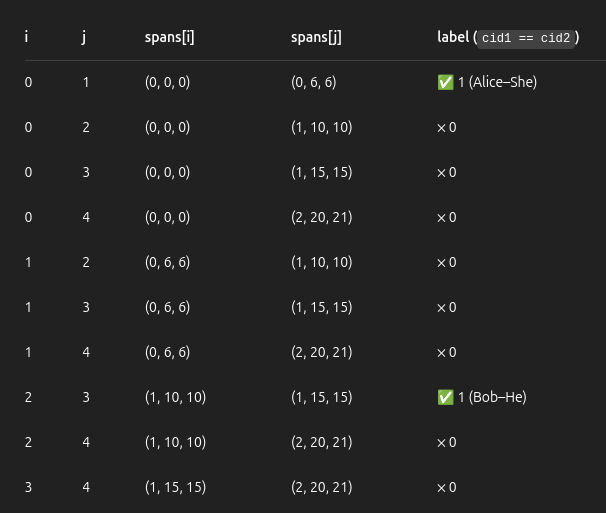

In [4]:
# Full Dataset Class
class MentionPairDataset(Dataset):
    def __init__(self, hf_dataset_split, tokenizer, score = False):
        self.doc_list = hf_dataset_split
        self.index = self.__build_index()
        self.tokenizer = tokenizer
        self.score = score # Bool

    def __build_index(self):
        # Flat list of (doc_idx, m1_idx, m2_idx) for pair access
        index = []

        for doc_idx, doc in enumerate(self.doc_list):
            _, spans = self.flatten_document(doc)

            for i in range(len(spans)):
                for j in range(i+1, len(spans)):
                    index.append((doc_idx, i, j))

        '''
           See attached figure above. 
        '''
        return index

    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx):
        doc_idx, i, j = self.index[idx]
        doc = self.doc_list[doc_idx]

        words, spans = self.flatten_document(doc)

        #print (words)
        #print (spans)
        
        (cid1, s1, e1) = spans[i]
        (cid2, s2, e2) = spans[j]
        label = torch.tensor(float(cid1 == cid2))

        text = self.create_truncated_text(words, (s1, e1), (s2, e2), self.tokenizer, score = self.score)

        return text, label


    def create_text(self, words, m1_span, m2_span):
        '''
            OBSOLETE NOTE: use create_truncated_text()
        '''
        w = words.copy()
        m1_start, m1_end = m1_span
        m2_start, m2_end = m2_span

        if m2_start < m1_start:
            (m1_start, m1_end), (m2_start, m2_end) = (m2_start, m2_end), (m1_start, m1_end)

        # Insert tokens in reverse order so indices stay valid
        w.insert(m2_end + 1, "</m>")
        w.insert(m2_start, "<m>")
        w.insert(m1_end + 1, "</m>")
        w.insert(m1_start, "<m>")

        text = " ".join(w)

        return text
    
    def create_truncated_text(self, words, m1_span, m2_span, tokenizer, max_length=512, context_window=122, score = False):
        """
        Truncate around mentions and ensure the final tokenized output includes both mentions
        and fits within the model's max_length.
        """

        if score == False:
            extra_token_num = 2 # [CLS] and [SEP]
        else:
            extra_token_num = 3 # [CLS], [SEP] and [S] = doc_score

        m1_start, m1_end = m1_span
        m2_start, m2_end = m2_span

        if m2_start < m1_start:
            (m1_start, m1_end), (m2_start, m2_end) = (m2_start, m2_end), (m1_start, m1_end)

        left_context_start = max(0, m1_start - context_window)
        left_context = words[left_context_start:m1_start]

        mention1 = words[m1_start:m1_end + 1]
        between_mentions = words[m1_end + 1:m2_start]
        mention2 = words[m2_start:m2_end + 1]

        right_context_end = min(len(words), m2_end + 1 + context_window)
        right_context = words[m2_end + 1:right_context_end]

        def get_tokens(seq):
            return tokenizer(seq, is_split_into_words=True, add_special_tokens=False)["input_ids"]

        while True:
            # Compose candidate
            seq = (
                left_context + ["<m>"] + mention1 + ["</m>"]
                + between_mentions + ["<m>"] + mention2 + ["</m>"]
                + right_context
            )
            token_ids = get_tokens(seq)

            # Add 2 for [CLS] and [SEP]
            if len(token_ids) + extra_token_num <= max_length:
                break

            # Prune in this order: between_mentions → left_context → right_context
            if len(between_mentions) > 0:
                between_mentions = between_mentions[1:-1]
            elif len(left_context) > 0:
                left_context = left_context[1:]
            elif len(right_context) > 0:
                right_context = right_context[:-1]
            else:
                break

        # Reconstruct string for final encoding
        final = (
            left_context + ["<m>"] + mention1 + ["</m>"]
            + between_mentions + ["<m>"] + mention2 + ["</m>"]
            + right_context
        )
        return " ".join(final)

    
    def flatten_document(self, document):
        words, spans = [],[]

        for sent in document['sentences']:
            offset = len(words)
            words.extend(sent['words'])

            for span in sent['coref_spans']:
                cluster_id, start, end = span
                spans.append((cluster_id, offset + start, offset + end))  # inclusive span

        # Example:
        '''words = [
                "Alice", "went", "to", "the", "market", ".",           
                "She", "bought", "apples", ".",                      
                "Bob", "was", "there", "too", ".",                    
                "He", "greeted", "her", ".",                           
                "The", "company", "was", "not", "far", "away", "."]

            spans = [
                    (0, 0, 0),  # "Alice"
                    (0, 6, 6),  # "She"          → same cluster as "Alice"
                    (1, 10, 10),# "Bob"
                    (1, 15, 15),# "He"           → same cluster as "Bob"
                    (2, 20, 21) # "The company"
                ]'''


        return words, spans    # full text, all coref spans


    def generate_mention_pairs(self, spans):
        """
        Returns list of (span1, span2, label)
        """
        mention_pairs = []
        for i in range(len(spans)):
            for j in range(i+1, len(spans)):
                id1, start1, end1 = spans[i]
                id2, start2, end2 = spans[j]
                label = int(id1 == id2)
                mention_pairs.append(((start1, end1), (start2, end2), label))
        
        # i.e. (mention1, mention2, label == 0 or 1)
        return mention_pairs

In [5]:
train = MentionPairDataset(ds['train'], tokenizer=tokenizer, score=False)  # Gets truncated text centered around mention spans.
train_loader = DataLoader(train, batch_size=1, num_workers = 2, shuffle = True, pin_memory=True)

### Need to extract embeddings from the final layer of transformer

In [6]:
def extract_mention_repr(input_ids, hidden_states, m_token_id, m_end_token_id):
    """
    Extract [CLS, mention1, mention2, mention1*mention2] representation from hidden states...similar to the paper.
    Returns a tensor of shape (batch_size, 4 * hidden_dim)
    """

    batch_size = input_ids.size(0)
    hidden_size = hidden_states.size(-1)
    reps = []

    for i in range(batch_size):
      ids = input_ids[i]          # (seq_len,)
      hs = hidden_states[i]       # (seq_len, hidden_dim)

      # Get CLS token (assume at index 0)
      cls_vec = hs[0]            # (hidden_dim of CLS token)

      # Find all <m> and </m> positions
      m_starts = (ids == m_token_id).nonzero(as_tuple=True)[0]
      m_ends = (ids == m_end_token_id).nonzero(as_tuple=True)[0]

      if len(m_starts) != 2 or len(m_ends) != 2:
        raise ValueError("Expected exactly two <m> and two </m> markers per example")
      
      # Mention 1
      start1 = m_starts[0].item() + 1
      end1 = m_ends[0].item()
      mention1_vec = hs[start1:end1].sum(dim=0)   # (hidden_dim,)

      # Mention 2
      start2 = m_starts[1].item() + 1
      end2 = m_ends[1].item()
      mention2_vec = hs[start2:end2].sum(dim=0)   # (hidden_dim,)

      # Elementwise product
      mention_product = mention1_vec * mention2_vec

      #print("Mention 1 span:", start1, "to", end1, "->", tokenizer.convert_ids_to_tokens(ids[start1:end1]))
      #print("Mention 2 span:", start2, "to", end2, "->", tokenizer.convert_ids_to_tokens(ids[start2:end2]))

      # Final representation 
      concat = torch.cat([cls_vec, mention1_vec, mention2_vec, mention_product], dim =-1) # (4 * hidden_dim,)
      reps.append(concat)
  
    return torch.stack(reps)  # (batch_size, 4 * hidden_dim)


### Main Training Loop - Run This

Something weird is going on in "for i, (batch_x, batch_y) in enumerate(train_loader)" below. Takes a long time to execute...need to look into it. However, the forward pass to the model shpuld be fast.

In [7]:
num_epochs = 5

m_id = tokenizer.convert_tokens_to_ids('<m>')
m_end_id = tokenizer.convert_tokens_to_ids('</m>')

for epoch in range(num_epochs):
    model.train()
    classifier.train()

    total_loss = 0.0
    all_preds = []
    all_labels = []


    for i, (batch_x, batch_y) in enumerate(train_loader):
        
        bert_tokens = tokenizer(
            batch_x,
            padding = "max_length",
            max_length = 512,
            return_tensors = "pt",
            truncation = True,
            add_special_tokens = True
        )

        print ('Acquired batch_x, batch_y')
        print (type(batch_x))
        
        input_ids = bert_tokens['input_ids'].to(DEVICE)
        attention_mask = bert_tokens['attention_mask'].to(DEVICE)
        batch_y = batch_y.to(DEVICE)

        if len(input_ids) > 512:
            print(f"[Warning] Input {i} too long: {len(input_ids)} tokens")

        try:
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            hidden_states = outputs['last_hidden_state']     #(batch_size, token_len, hidden_dim)
            reps = extract_mention_repr(input_ids, hidden_states, m_id, m_end_id)
        except ValueError as e:
            tqdm.tqdm.write(f"[Skipping example {i}] Reason: {e}")
            continue

        logits = classifier(reps)
        loss = loss_fn(logits.squeeze(-1), batch_y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        print (f'Total_loss: {total_loss}')

        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        labels = batch_y.detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)


    # compute metrics at the end of each epoch
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Total Loss: {total_loss:.4f}")
    print(f"  Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}\n")

Token indices sequence length is longer than the specified maximum sequence length for this model (4486 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5727 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

### Debug Below if needed....

In [ ]:
'''batch_x = [
    "My friend <m> Alice </m> went to the store. <m> She </m> bought apples.",
    "The car <m> Tesla </m> is fast. <m> Elon </m> drives it."
]

batch_y = torch.tensor([1.0, 0.0])  # First example: coref, second: not coref

m_id = tokenizer.convert_tokens_to_ids('<m>')
m_end_id = tokenizer.convert_tokens_to_ids('</m>')

bert_tokens = tokenizer(batch_x, padding = "max_length", max_length = 512, return_tensors = "pt", truncation = False, add_special_tokens = True)
input_ids = bert_tokens['input_ids'].to(DEVICE)
attention_mask = bert_tokens['attention_mask'].to(DEVICE)

outputs = model(input_ids = input_ids, attention_mask = attention_mask)
hidden_states = outputs['last_hidden_state']     #(batch_size, token_len, hidden_dim)

reps = extract_mention_repr(input_ids, hidden_states, m_id, m_end_id)

logits = classifier(reps)
loss = loss_fn(logits.squeeze(-1), batch_y)'''